In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

#### UK-Region Model

Given NWP data, for each init_time and forecast horizon, apply a mask that will filter the nwp image for only data in the region of the UK. Mean-downsample the within-uk and outer-uk masked data to a single point and fit a model.

In [2]:
from gradboost_pv.models.region_filtered import build_datasets_from_local, load_all_variable_slices
from gradboost_pv.models.common import NWP_FPATH, GSP_FPATH

gsp = xr.open_zarr(GSP_FPATH)
nwp = xr.open_zarr(NWP_FPATH)

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)


/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/nowcasting_datamodel/models/forecast.py:196: SAWarning: This declarative base already contains a class with the same class name and module name as nowcasting_datamodel.models.forecast.ForecastValueYearMonth, and will be replaced in the string-lookup table.
  class ForecastValueYearMonth(ForecastValueSQLMixin, Base_Forecast):


Unable to import PVLive utils, please provide filenames with OpenGSP
Unable to import PVLive utils, please provide filenames with OpenGSP


In [3]:
from gradboost_pv.models.experiment import run_experiment, plot_feature_importances, plot_loss_metrics

results = dict()
covariates = dict()
model_hparams = {
    "objective": "reg:squarederror",
    "booster": "gbtree",
    "colsample_bylevel": 1,
    "colsample_bynode": 1,
    "colsample_bytree": 0.85,
    "early_stopping_rounds": None,
    "gamma": 0,
    "gpu_id": -1,
    "grow_policy": "depthwise",
    "importance_type": None,
    "interaction_constraints": "",
    "learning_rate": 0.005,
    "max_bin": 256,
    "max_cat_threshold": 64,
    "max_depth": 100,
    "max_leaves": 0,
    "min_child_weight": 5,
    "n_estimators": 1_500,
    "n_jobs": -1,
    "num_parallel_tree": 1,
    "predictor": "auto",
    "random_state": 0,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "sampling_method": "uniform",
    "scale_pos_weight": 1,
    "subsample": 0.65,
    "tree_method": "hist",
    "validate_parameters": 1,
    "verbosity": 1,
}


for step in range(0, 37):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X = load_all_variable_slices(step)
    X, y = build_datasets_from_local(X, gsp, nwp.coords["step"].values[step])
    # X, y = build_datasets_from_local(gsp, nwp.coords["step"].values[step])
    output = run_experiment(X, y, model_hparams, save_errors_locally=True, errors_local_save_file=f"/home/tom/local_data/uk_region_model_errors_step_{step}.p")
    results[step] = output
    covariates[step] = (X, y)
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35
Completed run for step 36


In [6]:
import pickle

with open('covariates.p', 'wb') as handle:
    pickle.dump(covariates, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print(a == b)

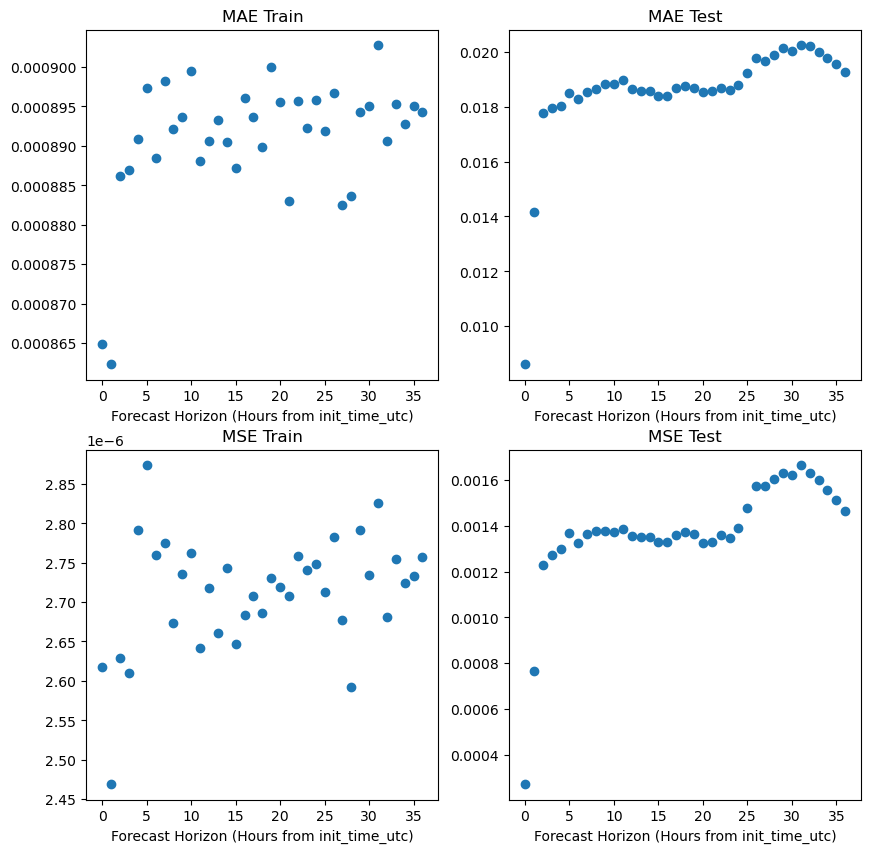

In [4]:
plot_loss_metrics(results)

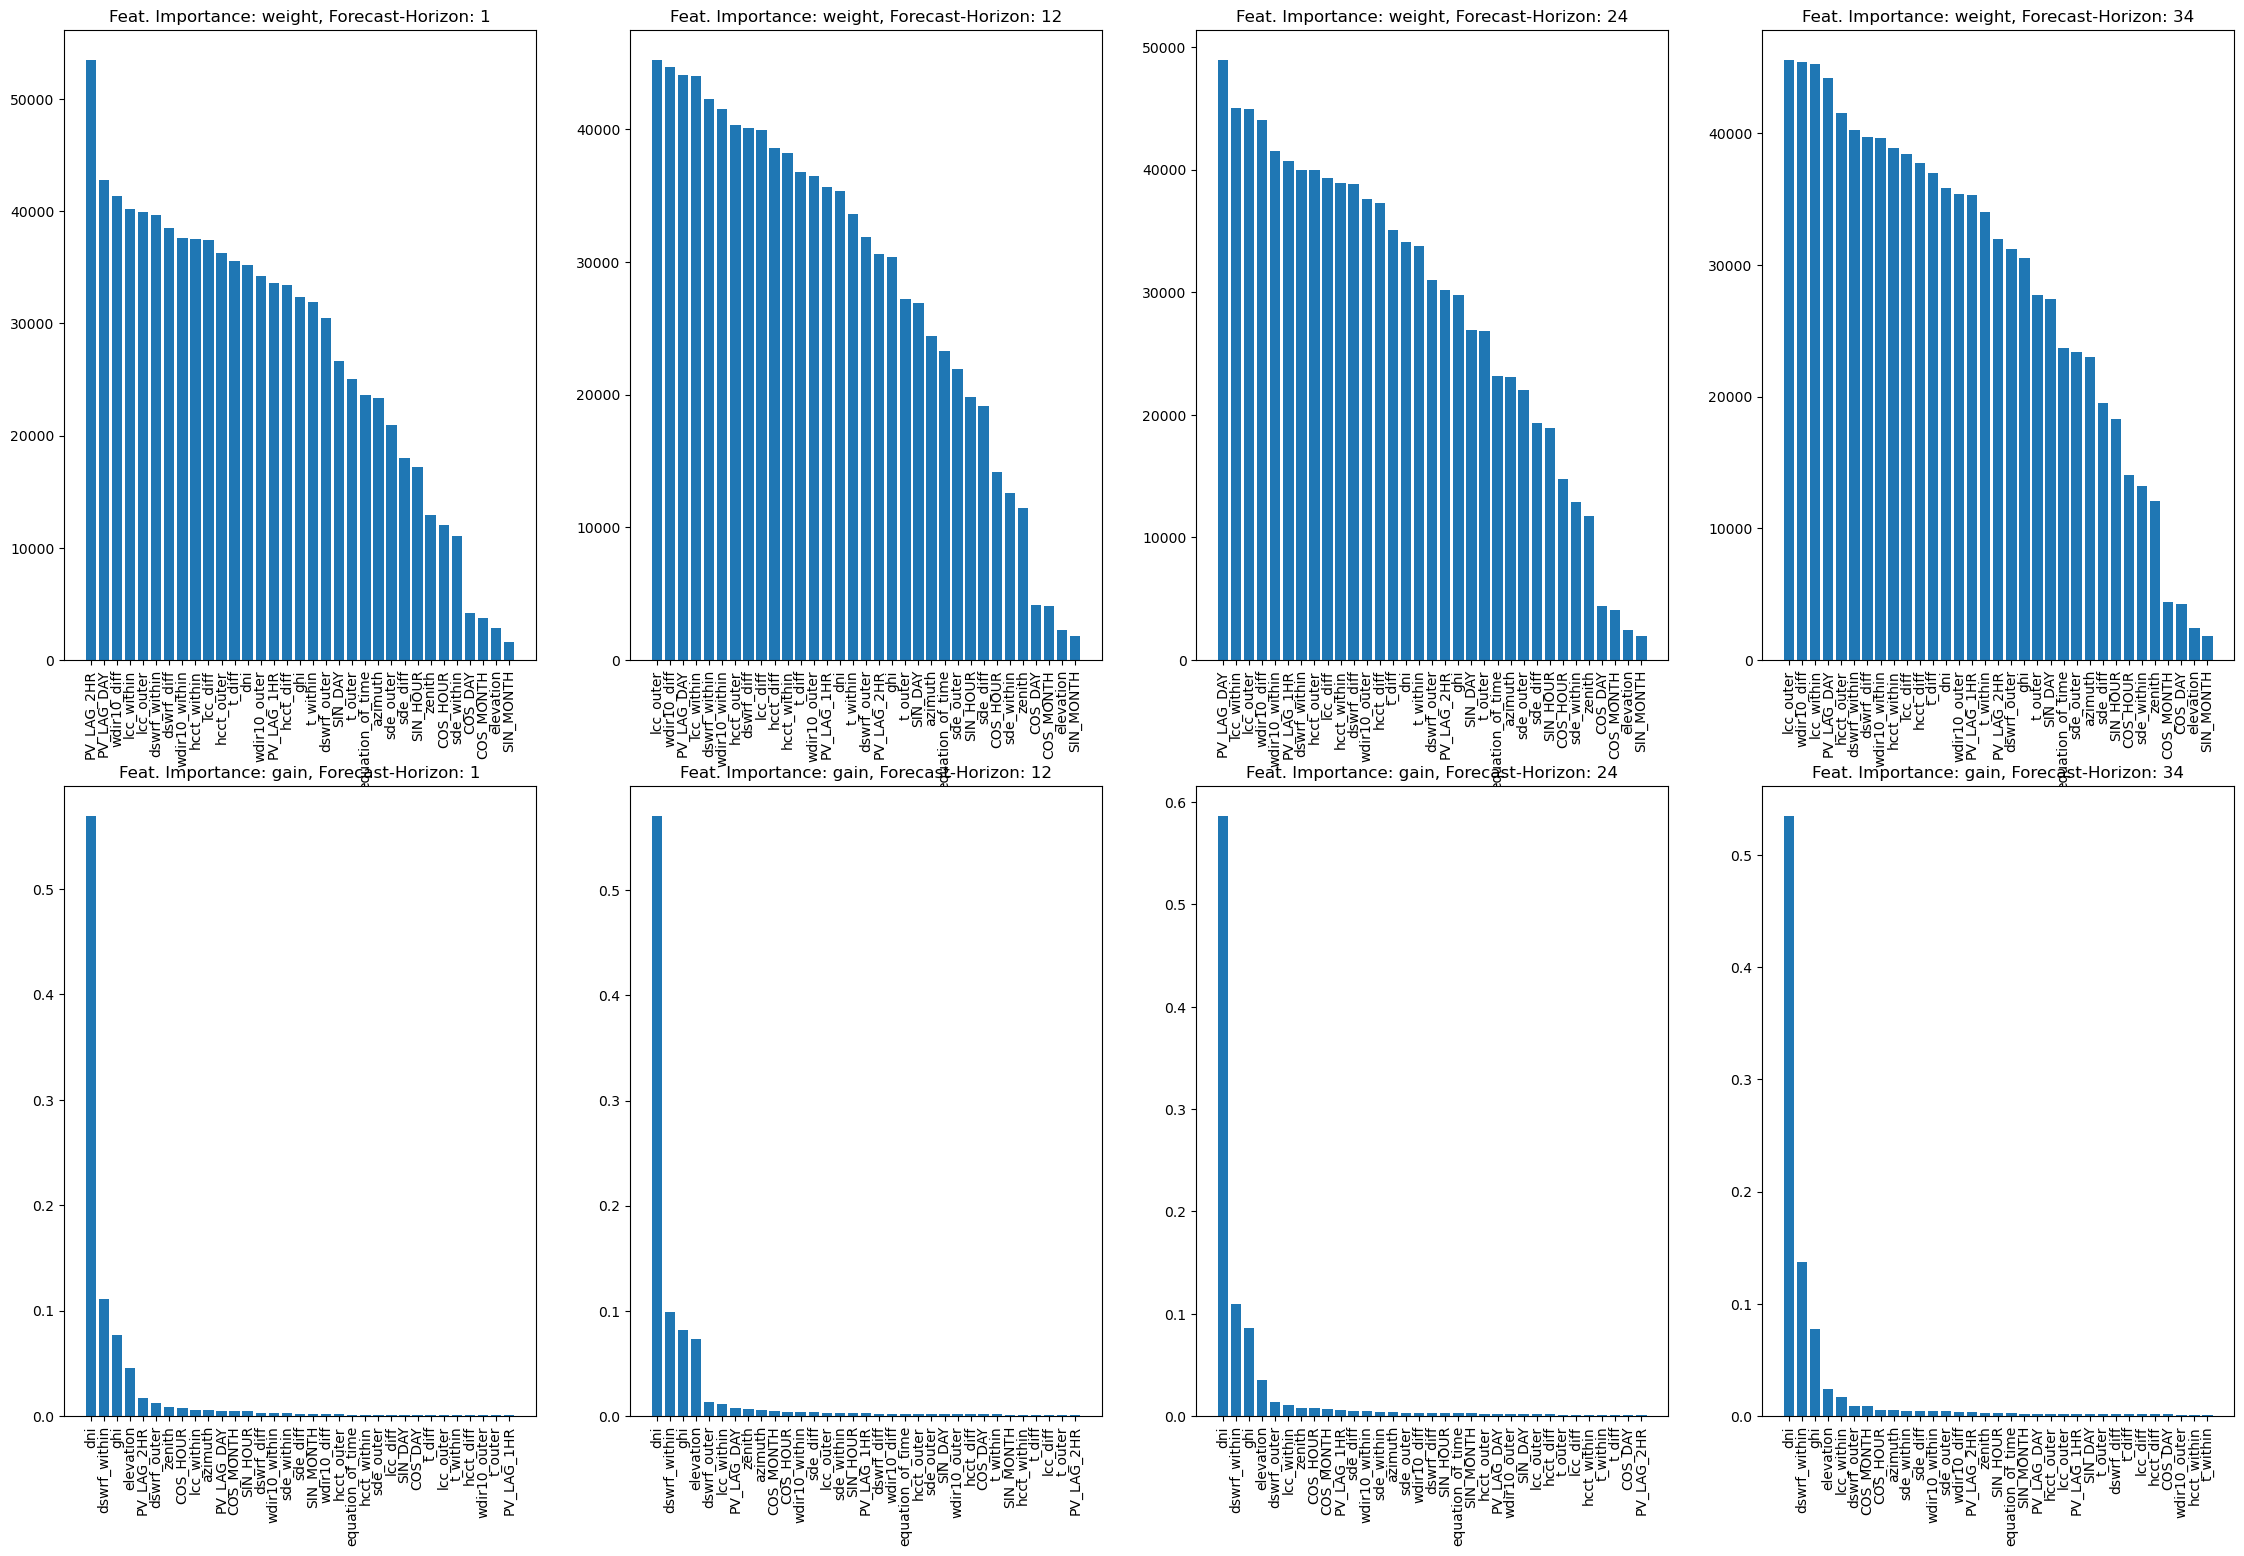

In [5]:
plot_feature_importances(results)

In [7]:
# for step in range(37):
#     _model = results[step].model
#     _model.save_model(f"/home/tom/dev/gradboost_pv/data/uk_region_model_step_{step}.model")

#### Comment

Best performing model. Next steps are to further investigate the hyperparameters of the model to reduce the generalisation error gap and fine tune performance.